# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Load and prepare the data

In [2]:
# Load training data
train_data = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')

# Load test data
test_data = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')

# Function to clean and prepare data
def prepare_data(df):
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df = df.copy()
    
    # Convert model_year and milage to numeric, but don't drop NaN values
    df['model_year'] = pd.to_numeric(df['model_year'], errors='coerce')
    df['milage'] = pd.to_numeric(df['milage'], errors='coerce')
    
    # Feature engineering
    current_year = 2024
    df['car_age'] = current_year - df['model_year']
    df['miles_per_year'] = df['milage'] / df['car_age']
    
    # Replace infinity values with NaN
    df = df.replace([np.inf, -np.inf], np.nan)
    
    return df

# Prepare train and test data
train_data = prepare_data(train_data)
test_data = prepare_data(test_data)

# Display info about the prepared datasets
print("Train data info:")
print(train_data.info())
print("\nTest data info:")
print(test_data.info())

Train data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              188533 non-null  int64  
 1   brand           188533 non-null  object 
 2   model           188533 non-null  object 
 3   model_year      188533 non-null  int64  
 4   milage          188533 non-null  int64  
 5   fuel_type       183450 non-null  object 
 6   engine          188533 non-null  object 
 7   transmission    188533 non-null  object 
 8   ext_col         188533 non-null  object 
 9   int_col         188533 non-null  object 
 10  accident        186081 non-null  object 
 11  clean_title     167114 non-null  object 
 12  price           188533 non-null  int64  
 13  car_age         188533 non-null  int64  
 14  miles_per_year  188371 non-null  float64
dtypes: float64(1), int64(5), object(9)
memory usage: 21.6+ MB
None

Test data info:
<clas

# Exploratory Data Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


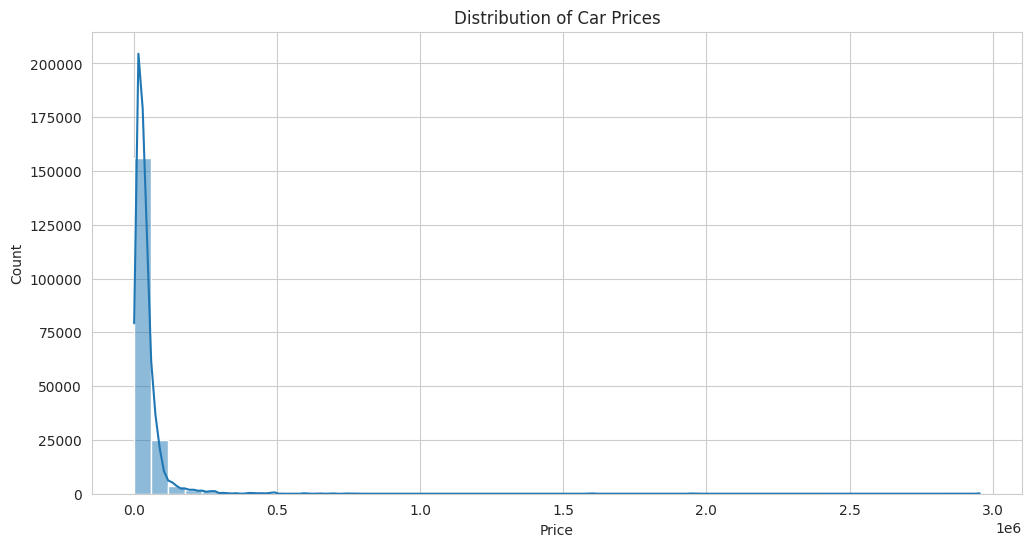

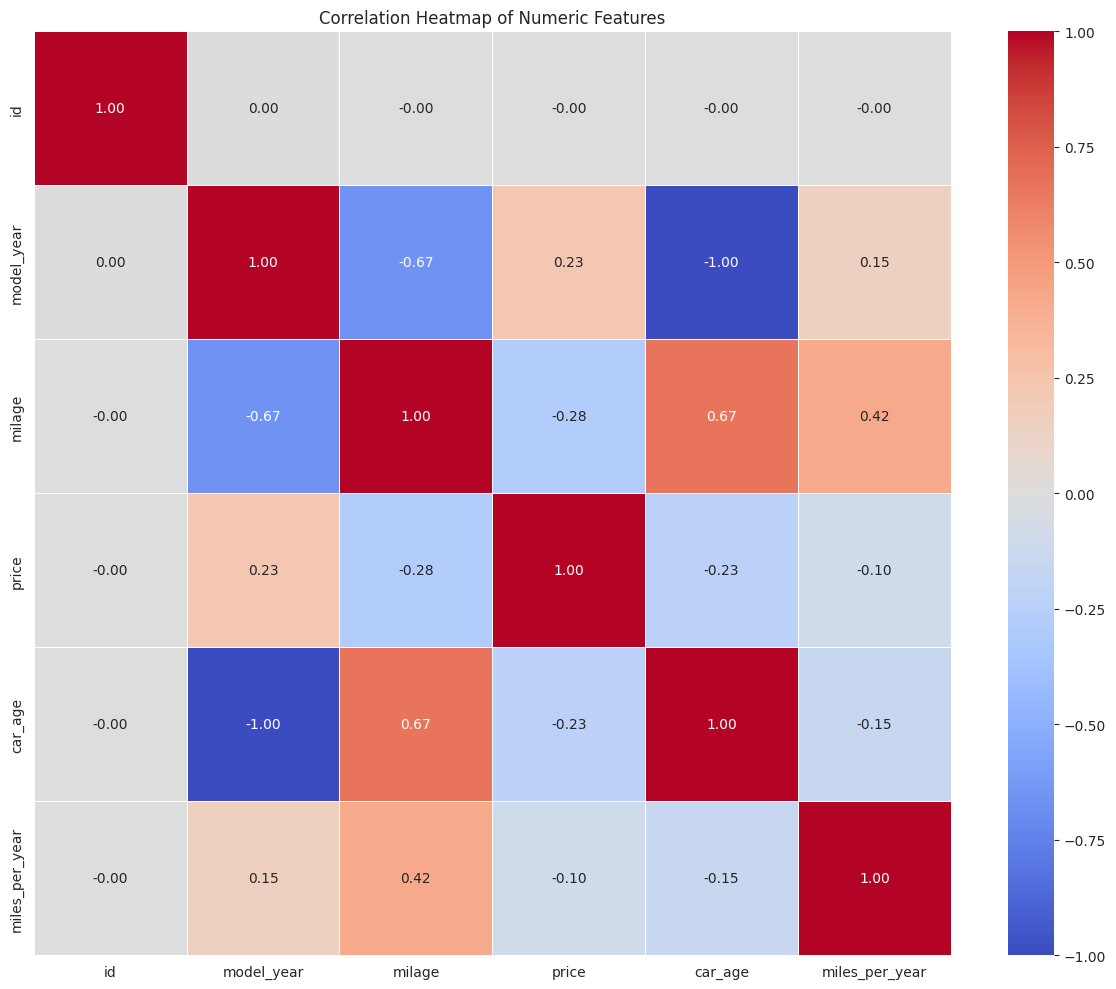

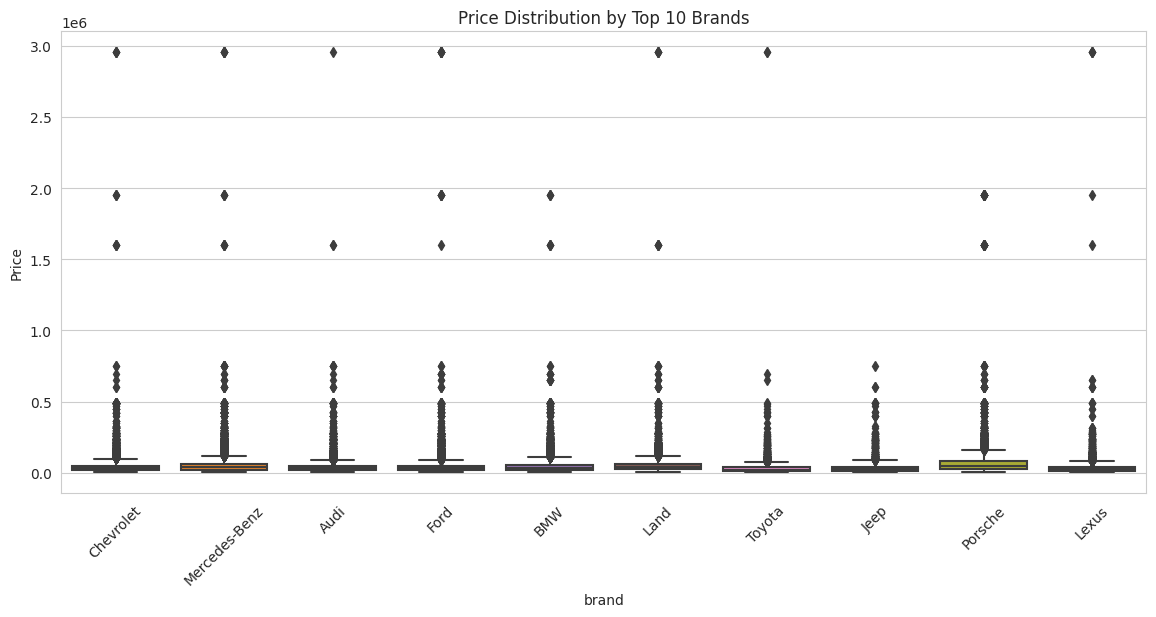

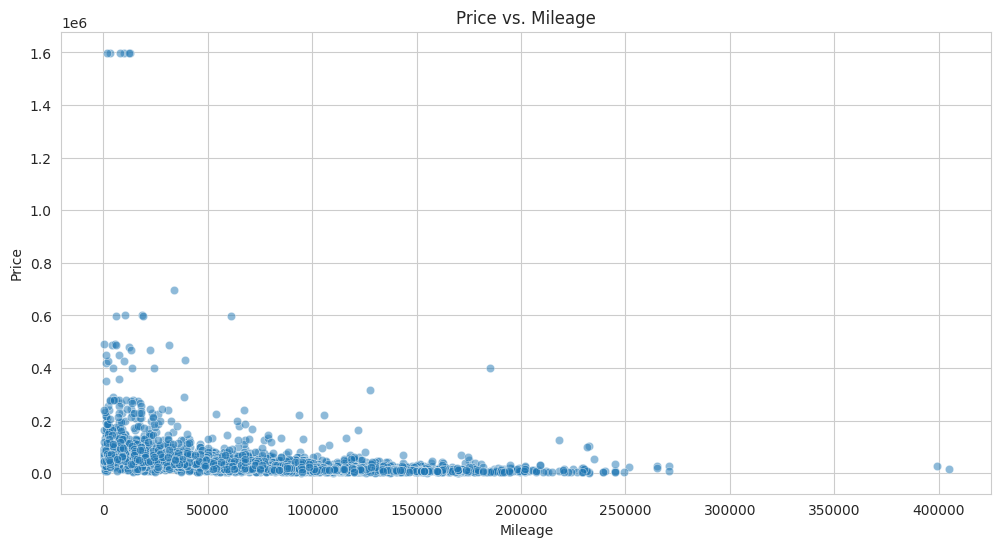

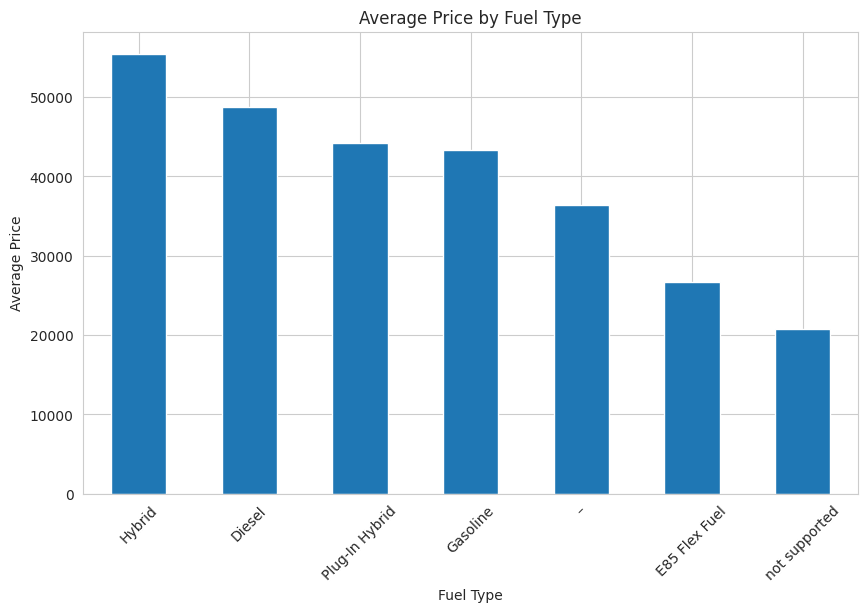

In [3]:
# Set the Seaborn style directly
sns.set_style("whitegrid")

# Function to replace inf with NaN
def replace_inf_with_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)

# Apply the function to your dataframe
train_data = replace_inf_with_nan(train_data)

# Distribution of target variable (price)
plt.figure(figsize=(12, 6))
sns.histplot(data=train_data, x='price', kde=True, bins=50)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

# Correlation heatmap
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
correlation_matrix = train_data[numeric_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

# Boxplot of prices by brand (top 10 brands)
top_10_brands = train_data['brand'].value_counts().nlargest(10).index
plt.figure(figsize=(14, 6))
sns.boxplot(data=train_data[train_data['brand'].isin(top_10_brands)], x='brand', y='price')
plt.title('Price Distribution by Top 10 Brands')
plt.xticks(rotation=45)
plt.ylabel('Price')
plt.show()

# Scatter plot of price vs. mileage
plt.figure(figsize=(12, 6))
sns.scatterplot(data=train_data.sample(5000), x='milage', y='price', alpha=0.5)
plt.title('Price vs. Mileage')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

# Bar plot of average price by fuel type
plt.figure(figsize=(10, 6))
train_data.groupby('fuel_type')['price'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Average Price by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

# Feature selection and encoding

In [4]:
features = ['brand', 'model', 'model_year', 'milage', 'fuel_type', 'transmission', 'ext_col', 'car_age', 'miles_per_year']
target = 'price'

# Function to encode categorical variables
def encode_categorical(train_df, test_df, categorical_columns):
    encoders = {}
    for column in categorical_columns:
        le = LabelEncoder()
        train_df[column] = le.fit_transform(train_df[column].astype(str))
        test_df[column] = test_df[column].astype(str).map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
        encoders[column] = le
    return train_df, test_df, encoders

categorical_columns = ['brand', 'model', 'fuel_type', 'transmission', 'ext_col']
train_data, test_data, label_encoders = encode_categorical(train_data, test_data, categorical_columns)

# Prepare features and target
features = ['brand', 'model', 'model_year', 'milage', 'fuel_type', 'transmission', 'ext_col', 'car_age', 'miles_per_year']
X = train_data[features]
y = train_data['price']
X_test = test_data[features]

# Fill NaN values with median
X = X.fillna(X.median())
X_test = X_test.fillna(X.median())  # Use train data median for test data

# Split the data and scale features

In [5]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Data split and scaled successfully.")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Validation set shape: {X_val_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

# Check for any remaining issues
print("\nChecking for remaining issues:")
print("NaN values in X_train_scaled:", np.isnan(X_train_scaled).sum())
print("Inf values in X_train_scaled:", np.isinf(X_train_scaled).sum())
print("NaN values in X_val_scaled:", np.isnan(X_val_scaled).sum())
print("Inf values in X_val_scaled:", np.isinf(X_val_scaled).sum())
print("NaN values in X_test_scaled:", np.isnan(X_test_scaled).sum())
print("Inf values in X_test_scaled:", np.isinf(X_test_scaled).sum())

Data split and scaled successfully.
Training set shape: (150826, 9)
Validation set shape: (37707, 9)
Test set shape: (125690, 9)

Checking for remaining issues:
NaN values in X_train_scaled: 0
Inf values in X_train_scaled: 0
NaN values in X_val_scaled: 0
Inf values in X_val_scaled: 0
NaN values in X_test_scaled: 0
Inf values in X_test_scaled: 0


# Model training and hyperparameter tuning

In [6]:
rf_model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

best_rf_model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.0min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.0min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.8min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.8min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 3.7min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.8min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.8min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 3.5min


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.0min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.0min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.8min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.8min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 3.6min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 3.8min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 3.5min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.0min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.0min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estim

# Model evaluation

In [7]:
y_pred_val = best_rf_model.predict(X_val_scaled)
mse = mean_squared_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Cross-validation
cv_scores = cross_val_score(best_rf_model, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"Cross-validation R-squared scores: {cv_scores}")
print(f"Mean CV R-squared score: {np.mean(cv_scores)}")

Mean Squared Error: 4917449874.266091
R-squared Score: 0.11574721219703932
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.7min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.8min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 3.5min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.6min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 3.3min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.6min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.6min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 3.1min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.5min
[CV] END m

# Predict on test data and create submission file

In [8]:
y_pred_test = best_rf_model.predict(X_test_scaled)

submission = pd.DataFrame({'id': test_data['id'], 'price': y_pred_test})
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully.")

Submission file created successfully.
